# 1 차원 함수 GAN 실습

이 문서는 아래 자료를 참고하여 실습하면서 작성한 노트북입니다.

* [How to Develop a 1D Generative Adversarial Network From Scratch in Keras](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/), Jason Brownlee

## 1 차원 함수 선택

1 차원 변수 $x$의 거듭제곱 함수를 실습의 대상으로 선택합니다.

$$
f(x) = x^2
$$

In [1]:
def calculate(x):
    return x * x

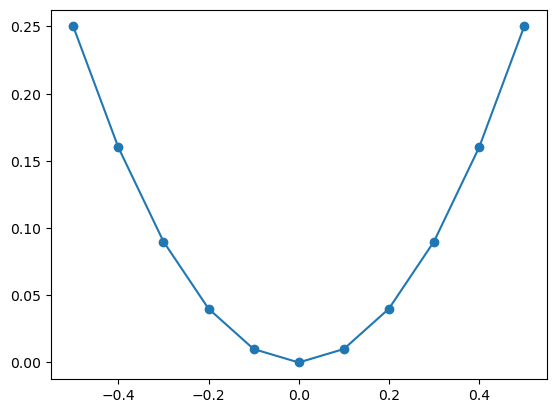

In [2]:
from matplotlib import pyplot

inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
outputs = [calculate(x) for x in inputs]

pyplot.plot(inputs, outputs, marker='o')
pyplot.show()

함수의 곡선 상에 존재하는 점 100 개를 무작위로 생성해서 그려 봅니다.

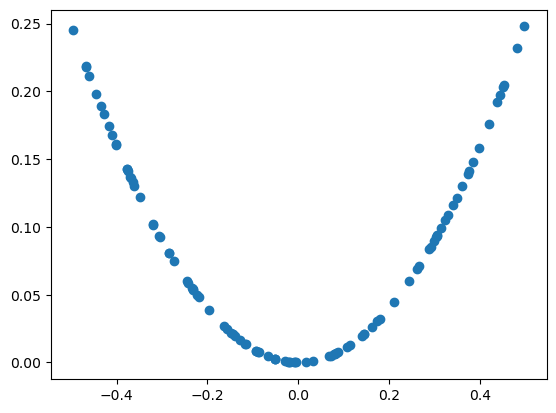

In [3]:
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot

def generate_samples(n=100):
    X1 = rand(n) - 0.5
    X2 = X1 * X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    return hstack((X1, X2))

data = generate_samples()
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

## 판별자 모델 정의

판별자의 입력 데이터는 2 차원 벡터이고 출력 데이터는 이진 분류를 위한 1차원 값입니다.

2024-04-12 12:18:59.665893: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 12:18:59.667595: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 12:18:59.689396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 12:18:59.689421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 12:18:59.690299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101 (404.00 Byte)
Trainable params: 101 (404.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


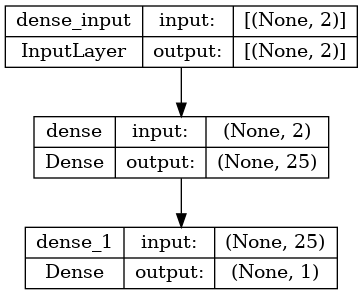

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

함수를 통해서 생성하는 입력 데이터에 대한 분류 값을 1로 지정합니다. 입력 데이터의 값의 범위는 -0.5 ~ 0.5 입니다.

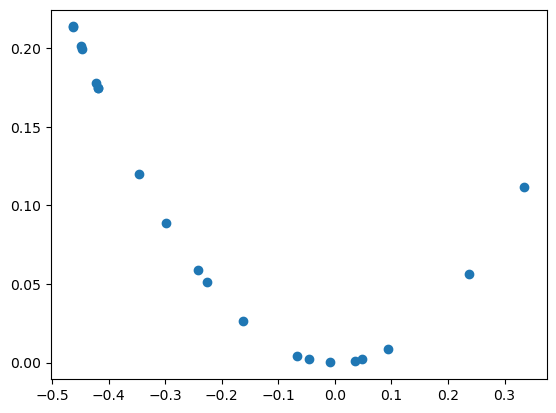

In [5]:
from numpy import ones

def generate_real_samples(n):
    X1 = rand(n) - 0.5
    X2 = X1 * X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    X = hstack((X1, X2))
    y = ones((n, 1))
    
    return X, y

real_X, real_y = generate_real_samples(20)

pyplot.scatter(real_X[:, 0], real_X[:, 1])
pyplot.show()

무작위로 생성하는 입력 데이터에 대한 분류 값을 0으로 지정합니다. 입력 데이터의 값의 범위는 -1.0 ~ 1.0 입니다.

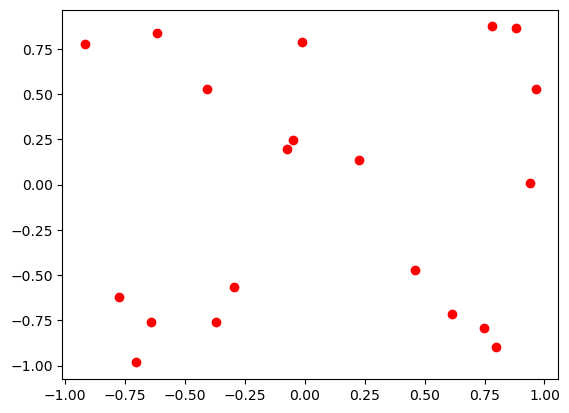

In [6]:
from numpy import zeros

def generate_fake_samples(n):
    X1 = -1 + rand(n) * 2
    X2 = -1 + rand(n) * 2

    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    X = hstack((X1, X2))
    y = zeros((n, 1))
    
    return X, y

fake_X, fake_y = generate_fake_samples(20)

pyplot.scatter(fake_X[:, 0], fake_X[:, 1], color='red')
pyplot.show()

실제 데이터와 가상 데이터로 판별자 모델을 훈련시킵니다.

In [7]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    
    # run epochs manually
    for i in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        X_fake, y_fake = generate_fake_samples(half_batch)

        model.train_on_batch(X_real, y_real)
        model.train_on_batch(X_fake, y_fake)
        
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        
        if i < 5 or (n_epochs - 5) <= i or (i % 100 == 0):
            print(f'[{i:>04}] {acc_real:6.2f} {acc_fake:6.2f}')

In [8]:
model = define_discriminator()
train_discriminator(model)

[0000]   0.44   0.28
[0001]   0.50   0.12
[0002]   0.55   0.31
[0003]   0.47   0.27
[0004]   0.47   0.23
[0100]   0.27   0.42
[0200]   0.45   0.73
[0300]   0.33   0.95
[0400]   0.73   0.95
[0500]   0.80   0.94
[0600]   0.89   0.94
[0700]   0.97   0.91
[0800]   0.97   0.91
[0900]   1.00   0.88
[0995]   1.00   0.84
[0996]   1.00   0.94
[0997]   1.00   0.80
[0998]   1.00   0.84
[0999]   1.00   0.84


## 생성자 모델 정의

생성자의 입력 데이터는 지정한 차원의 잠재 변수 벡터이고 출력 데이터는 2 차원 벡터입니다.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                90        
                                                                 
 dense_5 (Dense)             (None, 2)                 32        
                                                                 
Total params: 122 (488.00 Byte)
Trainable params: 122 (488.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


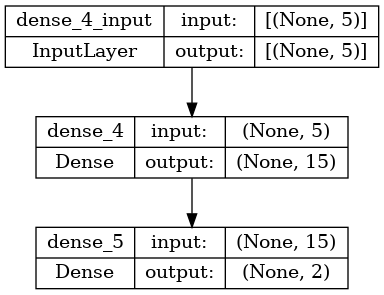

In [9]:
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

model = define_generator(5)
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

잠재 변수 벡터들을 생성합니다.

In [10]:
from numpy.random import randn

def generate_latent_points(latent_dim, n):
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

잠재 변수 벡터들을 생성자에 입력하여 가상 데이터를 생성합니다.

In [11]:
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    
    pyplot.scatter(X[:, 0], X[:, 1])
    pyplot.show()

4/4 [==============================] - 0s 926us/step


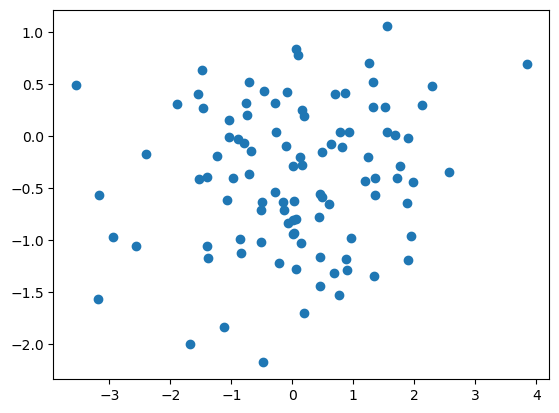

In [12]:
latent_dim = 5
model = define_generator(latent_dim)
generate_fake_samples(model, latent_dim, 100)

## 생성자 모델 훈련

GAN 모델을 통해서 생성자 모델을 훈련시킵니다. 여기서 판별자는 훈련시키지 않습니다.

In [13]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 2)                 122       
                                                                 
 sequential_4 (Sequential)   (None, 1)                 101       
                                                                 
Total params: 223 (892.00 Byte)
Trainable params: 122 (488.00 Byte)
Non-trainable params: 101 (404.00 Byte)
_________________________________________________________________


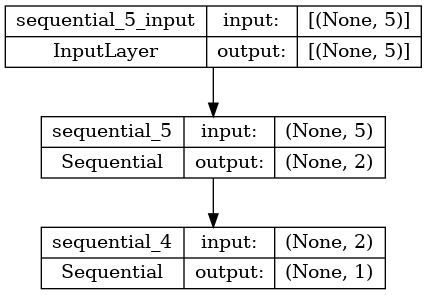

In [14]:
latent_dim = 5

discriminator = define_discriminator()
generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

판별자의 훈련 데이터는 다음과 같습니다.

* 입력: 실제 데이터, 가상 데이터
* 출력: 1 (실제 데이터의 경우), 0 (가상 데이터의 경우)

생성자를 훈련시키기 위한 GAN의 훈련 데이터는 다음과 같습니다.

* 입력: 잠재 변수 벡터
* 출력: 1 (판별자를 속이는 쪽으로 생성자를 훈련시키기 위함)

In [16]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

## GAN 성능 평가

In [17]:
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    X2 = X1 * X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    X = hstack((X1, X2))
    y = ones((n, 1))
    
    return X, y

In [18]:
def generate_latent_points(latent_dim, n):
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [19]:
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = zeros((n, 1))
    return X, y

In [20]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='blue', label='real')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='red', label='fake')
    pyplot.legend()
    pyplot.show()

In [21]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)
        
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 765us/step
1999 0.4099999964237213 1.0


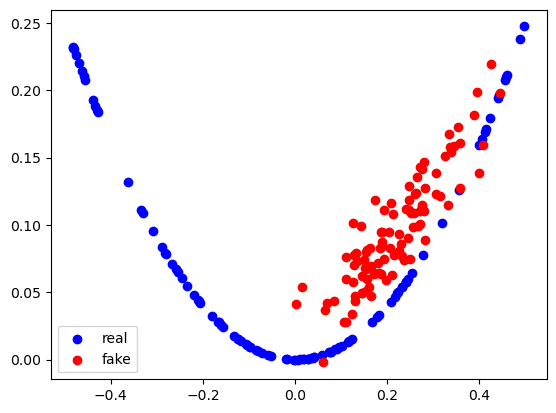

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 985us/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 987us/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 777us/step
3999 0.4300000071525574 1.0


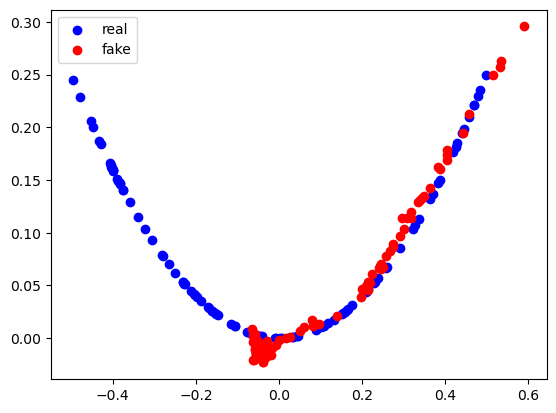

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 983us/step


4/4 [==============================] - 0s 762us/step
5999 0.8299999833106995 0.11999999731779099


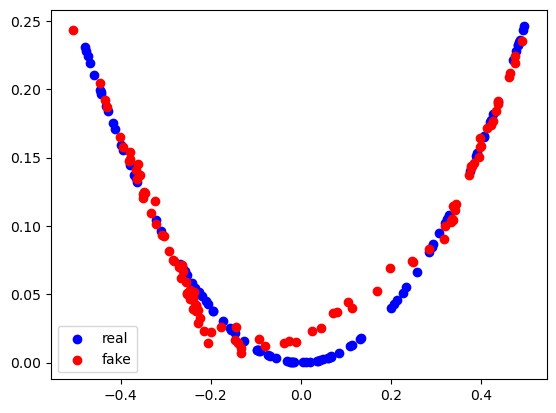

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 956us/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 919us/step
7999 0.6800000071525574 0.5099999904632568


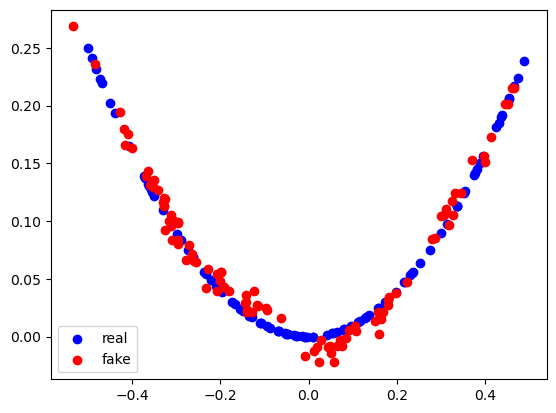

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 899us/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 726us/step
9999 0.5899999737739563 0.4000000059604645


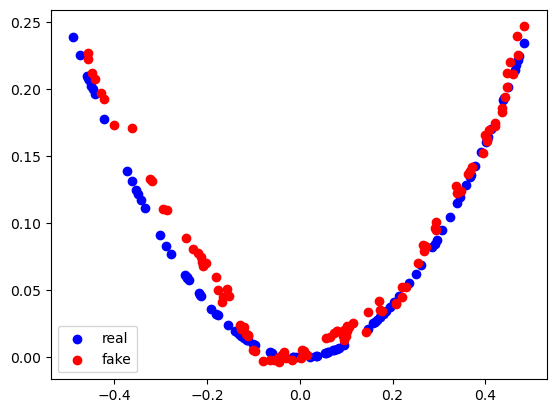

In [22]:
latent_dim = 5

discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

train(generator, discriminator, gan_model, latent_dim)